# ViT + FastFlow para Detección de Anomalías en Placas MDP

Este notebook implementa un sistema completo de detección de anomalías usando Vision Transformer (ViT) y FastFlow.

## Características principales:
- **Entrenamiento solo con imágenes buenas** para detectar anomalías
- **Clasificación de tipo de tablero** (extraída del nombre del archivo)
- **Detección de defectos** con scores de anomalía
- **Generación de heatmaps** para visualizar anomalías
- **Métricas de evaluación** completas
- **Checkpoint automático** para evitar reentrenamiento
- **Conversión automática a RGB** para imágenes monocromáticas

## Estructura del dataset:
Dataset_fastflow/
├── train/ # Solo imágenes buenas para entrenamiento
├── val/ # Solo imágenes buenas para validación
└── test/ # Imágenes buenas y defectuosas para evaluación

test_defectos/ # Imágenes con defectos (opcional)


## Nomenclatura de archivos:
- `20241012_125852_0.jpg` → Clase 0 (último dígito)
- `aug_00014_2.jpg` → Clase 2 (último dígito)"""))

In [1]:
# Importaciones básicas
import os
import sys
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# PyTorch y relacionados
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.distributions import MultivariateNormal

# Transformers y ViT
from transformers import ViTModel, ViTConfig

# Visión por computadora
import torchvision.transforms as transforms
from PIL import Image
import cv2

# Métricas y evaluación
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

# Utilidades
from tqdm import tqdm
import logging

# Configurar logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Configurar matplotlib
plt.style.use('default')
sns.set_palette('husl')

# Verificar CUDA
print('Configuración del sistema:')
print(f'   - Python: {sys.version.split()[0]}')
print(f'   - PyTorch: {torch.__version__}')
print(f'   - CUDA disponible: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'   - GPU: {torch.cuda.get_device_name(0)}')
    print(f'   - Memoria GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB')
print(f'   - Número de CPUs: {os.cpu_count()}')

Configuración del sistema:
   - Python: 3.11.0
   - PyTorch: 2.3.0+cu121
   - CUDA disponible: True
   - GPU: NVIDIA GeForce RTX 3080 Ti
   - Memoria GPU: 12.9 GB
   - Número de CPUs: 32


In [2]:
class Config:   
    # Rutas de datos
    DATASET_PATH = './Dataset_fastflow'
    DEFECT_PATH = './defectos' 
    
    # Parámetros de imagen
    IMAGE_SIZE = 224
    USE_RGB = True  # Convertir imágenes monocromáticas a RGB
    
    # Parámetros de entrenamiento
    BATCH_SIZE = 16
    NUM_EPOCHS = 50
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 1e-5
    
    # Early stopping
    PATIENCE = 10
    MIN_DELTA = 1e-4
    
    # Modelo
    VIT_MODEL = 'google/vit-base-patch16-224'
    FREEZE_VIT = True
    FASTFLOW_HIDDEN_DIM = 512
    FASTFLOW_NUM_LAYERS = 4
    
    # Hardware
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    NUM_WORKERS = 0  # Para Jupyter, usar 0
    PIN_MEMORY = torch.cuda.is_available()
    
    # Archivos de salida
    MODEL_SAVE_PATH = 'best_model_vit_fastflow.pth'
    METRICS_SAVE_PATH = 'training_metrics.json'
    PLOTS_SAVE_PATH = 'training_plots.png'
    
    # Visualización
    FIGSIZE = (15, 10)
    DPI = 300
    
    def __repr__(self):
        return f'Config(device={self.DEVICE}, batch_size={self.BATCH_SIZE}, lr={self.LEARNING_RATE})'

# Crear instancia de configuración
config = Config()

print('Configuración cargada:')
print(f'   - Dataset: {config.DATASET_PATH}')
print(f'   - Imagen: {config.IMAGE_SIZE}x{config.IMAGE_SIZE} RGB={config.USE_RGB}')
print(f'   - Batch size: {config.BATCH_SIZE}')
print(f'   - Learning rate: {config.LEARNING_RATE}')
print(f'   - Device: {config.DEVICE}')
print(f'   - Épocas máximas: {config.NUM_EPOCHS}')
print(f'   - Early stopping patience: {config.PATIENCE}')

Configuración cargada:
   - Dataset: ./Dataset_fastflow
   - Imagen: 224x224 RGB=True
   - Batch size: 16
   - Learning rate: 0.0001
   - Device: cuda
   - Épocas máximas: 50
   - Early stopping patience: 10


In [3]:
class MDPDataset(Dataset):
    def __init__(self, data_dir, transform=None, defect_dir=None, mode='train'):
        """Args
            data_dir (str): Directorio con imágenes (train/val/test)
            transform: Transformaciones a aplicar
            defect_dir (str): Directorio con imágenes defectuosas (opcional)
            mode (str): 'train', 'val', o 'test'"""
        
        self.data_dir = data_dir
        self.defect_dir = defect_dir
        self.transform = transform
        self.mode = mode
        
        # Extensiones de imagen válidas
        self.valid_extensions = {'.png', '.jpg', '.jpeg', '.bmp', '.tiff'}
        
        # Cargar lista de imágenes
        self.image_paths = []
        self.labels = []  # 0 = buena, 1 = defectuosa
        self.classes = []  # clase extraída del nombre del archivo
        
        self._load_images()
        
        print(f'Dataset {mode} cargado:')
        print(f'   - Total imágenes: {len(self.image_paths)}')
        print(f'   - Imágenes buenas: {sum(1 for l in self.labels if l == 0)}')
        print(f'   - Imágenes defectuosas: {sum(1 for l in self.labels if l == 1)}')
        print(f'   - Clases únicas: {len(set(self.classes))}')
    
    def _load_images(self):
        """Carga las rutas de imágenes y sus etiquetas"""
        
        # 1. Cargar imágenes buenas del directorio principal
        if os.path.exists(self.data_dir):
            for filename in os.listdir(self.data_dir):
                if self._is_valid_image(filename):
                    image_path = os.path.join(self.data_dir, filename)
                    class_id = self._extract_class_from_filename(filename)
                    
                    self.image_paths.append(image_path)
                    self.labels.append(0)  # 0 = imagen buena
                    self.classes.append(class_id)
        
        # 2. Cargar imágenes defectuosas si se especifica el directorio
        if self.defect_dir and os.path.exists(self.defect_dir):
            for filename in os.listdir(self.defect_dir):
                if self._is_valid_image(filename):
                    image_path = os.path.join(self.defect_dir, filename)
                    class_id = self._extract_class_from_filename(filename)
                    
                    self.image_paths.append(image_path)
                    self.labels.append(1)  # 1 = imagen defectuosa
                    self.classes.append(class_id)
    
    def _is_valid_image(self, filename):
        """Verifica si el archivo es una imagen válida"""
        return any(filename.lower().endswith(ext) for ext in self.valid_extensions)
    
    def _extract_class_from_filename(self, filename):
        """Extrae la clase del nombre del archivo
        Ejemplos:
        - 20241012_125852_0.jpg → Clase 0
        - aug_00014_2.jpg → Clase 2
        """
        # Remover extensión
        name_without_ext = os.path.splitext(filename)[0]
        
        # Buscar el último underscore y extraer el número
        parts = name_without_ext.split('_')
        
        if len(parts) >= 2:
            try:
                # El último elemento después del underscore es la clase
                class_id = int(parts[-1])
                return class_id
            except ValueError:
                # Si no se puede convertir a int, usar 0 como default
                logger.warning(f'No se pudo extraer clase de {filename}, usando clase 0')
                return 0
        else:
            # Si no hay underscore, usar clase 0
            return 0
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        """Obtiene un elemento del dataset"""
        try:
            # Cargar imagen
            image_path = self.image_paths[idx]
            image = Image.open(image_path)
            
            # Convertir a RGB (importante para imágenes monocromáticas)
            image = image.convert('RGB')
            
            # Aplicar transformaciones
            if self.transform:
                image = self.transform(image)
            
            # Obtener etiquetas
            defect_label = self.labels[idx]
            class_label = self.classes[idx]
            
            return {
                'image': image,
                'defect': defect_label,  # 0 = buena, 1 = defectuosa
                'class': class_label,    # clase extraída del filename
                'path': image_path       # ruta del archivo
            }
        
        except Exception as e:
            logger.error(f'Error cargando imagen {self.image_paths[idx]}: {str(e)}')
            
            # Devolver una imagen en negro como fallback
            black_image = torch.zeros(3, config.IMAGE_SIZE, config.IMAGE_SIZE)
            
            return {
                'image': black_image,
                'defect': 0,
                'class': 0,
                'path': self.image_paths[idx]
            }
    
    def get_class_distribution(self):
        """Obtiene la distribución de clases"""
        class_counts = Counter(self.classes)
        defect_counts = Counter(self.labels)
        
        return {
            'classes': dict(class_counts),
            'defects': {0: defect_counts[0], 1: defect_counts.get(1, 0)}
        }
    
    def get_sample_paths(self, n_samples=5):
        """Obtiene rutas de muestra para verificación"""
        indices = np.random.choice(len(self.image_paths), 
                                 min(n_samples, len(self.image_paths)), 
                                 replace=False)
        
        samples = []
        for idx in indices:
            samples.append({
                'path': self.image_paths[idx],
                'defect': self.labels[idx],
                'class': self.classes[idx]
            })
        
        return samples

In [4]:
# Transformaciones para entrenamiento (con data augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])  # ImageNet stats
])

# Transformaciones para validación/test (sin data augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

print('Transformaciones definidas:')
print(f'   - Tamaño de imagen: {config.IMAGE_SIZE}x{config.IMAGE_SIZE}')
print(f'   - Normalización: ImageNet stats')
print(f'   - Data augmentation: Flip, Rotation, ColorJitter')

# Crear datasets y dataloaders
datasets = {}
dataloaders = {}

for split in ['train', 'val', 'test']:
    data_dir = os.path.join(config.DATASET_PATH, split)
    
    if os.path.exists(data_dir):
        # Usar transformaciones de entrenamiento solo para train
        transform = train_transforms if split == 'train' else val_transforms
        
        # Crear dataset
        datasets[split] = MDPDataset(
            data_dir=data_dir,
            transform=transform,
            defect_dir=config.DEFECT_PATH if split == 'test' else None,
            mode=split
        )
        
        # Crear dataloader
        dataloaders[split] = DataLoader(
            datasets[split],
            batch_size=config.BATCH_SIZE,
            shuffle=(split == 'train'),
            num_workers=config.NUM_WORKERS,
            pin_memory=config.PIN_MEMORY,
            drop_last=False
        )
        
        print(f'{split.capitalize()} dataset: {len(datasets[split])} imágenes')
    else:
        print(f'Directorio {data_dir} no encontrado, saltando {split}')

# Asignar dataloaders a variables específicas
train_loader = dataloaders.get('train')
val_loader = dataloaders.get('val')
test_loader = dataloaders.get('test')

# Mostrar información de los datasets
print('\\nResumen de datasets:')
for split, dataset in datasets.items():
    distribution = dataset.get_class_distribution()
    print(f'\\n{split.upper()}:')
    print(f'   - Total imágenes: {len(dataset)}')
    print(f'   - Distribución defectos: {distribution["defects"]}')
    print(f'   - Distribución clases: {distribution["classes"]}')
    
    # Mostrar algunas muestras
    samples = dataset.get_sample_paths(3)
    print(f'   - Muestras:')
    for i, sample in enumerate(samples):
        filename = os.path.basename(sample['path'])
        print(f'    {i+1}. {filename} (defect={sample["defect"]}, class={sample["class"]})')

# Probar un batch
if train_loader:
    print('\\nProbando un batch de entrenamiento...')
    batch = next(iter(train_loader))
    print(f'   - Batch shape: {batch["image"].shape}')
    print(f'   - Defect labels: {batch["defect"].tolist()}')
    print(f'   - Class labels: {batch["class"].tolist()}')
    print(f'   - Image stats: min={batch["image"].min():.3f}, max={batch["image"].max():.3f}')

Transformaciones definidas:
   - Tamaño de imagen: 224x224
   - Normalización: ImageNet stats
   - Data augmentation: Flip, Rotation, ColorJitter
Dataset train cargado:
   - Total imágenes: 1400
   - Imágenes buenas: 1400
   - Imágenes defectuosas: 0
   - Clases únicas: 4
Train dataset: 1400 imágenes
Dataset val cargado:
   - Total imágenes: 300
   - Imágenes buenas: 300
   - Imágenes defectuosas: 0
   - Clases únicas: 4
Val dataset: 300 imágenes
Dataset test cargado:
   - Total imágenes: 300
   - Imágenes buenas: 300
   - Imágenes defectuosas: 0
   - Clases únicas: 4
Test dataset: 300 imágenes
\nResumen de datasets:
\nTRAIN:
   - Total imágenes: 1400
   - Distribución defectos: {0: 1400, 1: 0}
   - Distribución clases: {0: 350, 3: 350, 2: 350, 1: 350}
   - Muestras:
    1. aug_00299_3.png (defect=0, class=3)
    2. aug_00162_1.png (defect=0, class=1)
    3. aug_00283_2.png (defect=0, class=2)
\nVAL:
   - Total imágenes: 300
   - Distribución defectos: {0: 300, 1: 0}
   - Distribución 

In [5]:
class ViTFeatureExtractor(nn.Module):
    """Extractor de características usando ViT preentrenado"""
    
    def __init__(self, model_name=None, freeze_backbone=True):
        super(ViTFeatureExtractor, self).__init__()
        
        if model_name is None:
            model_name = config.VIT_MODEL
        
        print(f'Cargando ViT: {model_name}')
        
        # Cargar modelo ViT preentrenado
        self.vit = ViTModel.from_pretrained(model_name)
        
        # Congelar parámetros del backbone si se especifica
        if freeze_backbone:
            for param in self.vit.parameters():
                param.requires_grad = False
            print('Parámetros de ViT congelados')
        else:
            print('Parámetros de ViT entrenables')
        
        # Dimensión de salida del ViT
        self.output_dim = self.vit.config.hidden_size  # 768 para ViT-base
        print(f'Dimensión de características: {self.output_dim}')
    
    def forward(self, x):
        """Extrae características de las imágenes"""
        outputs = self.vit(pixel_values=x)
        features = outputs.last_hidden_state
        return features

In [6]:
class CouplingLayer(nn.Module):
    """Capa de acoplamiento para el normalizing flow"""
    
    def __init__(self, input_dim, hidden_dim):
        super(CouplingLayer, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        # Dividir dimensiones
        self.split_dim = input_dim // 2
        
        # Redes para transformación
        self.scale_net = nn.Sequential(
            nn.Linear(self.split_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim - self.split_dim),
            nn.Tanh()
        )
        
        self.translate_net = nn.Sequential(
            nn.Linear(self.split_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim - self.split_dim)
        )
    
    def forward(self, x):
        """Forward pass de la capa de acoplamiento"""
        # Dividir input
        x1, x2 = x[:, :self.split_dim], x[:, self.split_dim:]
        
        # Calcular transformaciones
        scale = self.scale_net(x1)
        translate = self.translate_net(x1)
        
        # Aplicar transformación afín
        y1 = x1
        y2 = x2 * torch.exp(scale) + translate
        
        # Concatenar
        y = torch.cat([y1, y2], dim=1)
        
        # Log-determinante del Jacobiano
        log_det_jacobian = scale.sum(dim=1)
        
        return y, log_det_jacobian

class FastFlowModule(nn.Module):
    """Implementación de FastFlow para detección de anomalías"""
    
    def __init__(self, input_dim=768, hidden_dim=None, num_layers=None):
        super(FastFlowModule, self).__init__()
        
        if hidden_dim is None:
            hidden_dim = config.FASTFLOW_HIDDEN_DIM
        if num_layers is None:
            num_layers = config.FASTFLOW_NUM_LAYERS
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        print(f'Configurando FastFlow:')
        print(f'   - Input dim: {input_dim}')
        print(f'   - Hidden dim: {hidden_dim}')
        print(f'   - Num layers: {num_layers}')
        
        # Capas de normalizing flow
        self.flow_layers = nn.ModuleList()
        
        for i in range(num_layers):
            self.flow_layers.append(
                CouplingLayer(input_dim, hidden_dim)
            )
        
        # Distribución base (Gaussiana multivariada)
        self.register_buffer('base_mean', torch.zeros(input_dim))
        self.register_buffer('base_cov', torch.eye(input_dim))
    
    def forward(self, x):
        """Forward pass a través del flow"""
        batch_size, seq_len, _ = x.shape
        
        # Aplanar para procesar
        x_flat = x.view(-1, self.input_dim)
        
        z = x_flat
        log_det_jacobian = torch.zeros(x_flat.shape[0], device=x.device)
        
        # Pasar por las capas del flow
        for layer in self.flow_layers:
            z, ldj = layer(z)
            log_det_jacobian += ldj
        
        return z, log_det_jacobian
    
    def training_loss(self, x):
        """Calcula la pérdida de entrenamiento (negative log-likelihood)"""
        z, log_det_jacobian = self.forward(x)
        
        # Log-probabilidad bajo la distribución base
        base_dist = MultivariateNormal(self.base_mean, self.base_cov)
        log_prob_base = base_dist.log_prob(z)
        
        # Log-probabilidad total
        log_prob = log_prob_base + log_det_jacobian
        
        # Pérdida = negative log-likelihood
        loss = -log_prob.mean()
        
        return loss
    
    def anomaly_score(self, x):
        """Calcula el score de anomalía para las muestras"""
        with torch.no_grad():
            z, log_det_jacobian = self.forward(x)
            
            # Log-probabilidad bajo la distribución base
            base_dist = MultivariateNormal(self.base_mean, self.base_cov)
            log_prob_base = base_dist.log_prob(z)
            
            # Log-probabilidad total
            log_prob = log_prob_base + log_det_jacobian
            
            # Score de anomalía = -log_prob (mayor score = más anómalo)
            anomaly_scores = -log_prob
            
            # Promediar por secuencia si es necesario
            batch_size = x.shape[0]
            seq_len = x.shape[1]
            anomaly_scores = anomaly_scores.view(batch_size, seq_len).mean(dim=1)
            
            return anomaly_scores

In [ ]:
class ClassificationHead(nn.Module):
    """Cabeza de clasificación para predecir el tipo de placa"""
    
    def __init__(self, input_dim=768, num_classes=4, hidden_dim=256):
        super(ClassificationHead, self).__init__()
        
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim // 2, num_classes)
        )
        
        print(f'Clasificador creado: {input_dim} -> {num_classes} clases')
    
    def forward(self, x):
        cls_token = x[:, 0, :] 
        logits = self.classifier(cls_token)
        return logits

In [8]:
class ViT_FastFlow_Complete(nn.Module):
    """Modelo completo ViT + FastFlow + Clasificación para detección de anomalías"""
    
    def __init__(self, num_classes=4, device=None):
        super(ViT_FastFlow_Complete, self).__init__()
        
        if device is None:
            device = config.DEVICE
        
        print('Construyendo modelo ViT + FastFlow + Clasificación...')
        
        # ViT para extracción de características
        self.vit = ViTFeatureExtractor(
            model_name=config.VIT_MODEL,
            freeze_backbone=config.FREEZE_VIT
        )
        
        # FastFlow para detección de anomalías
        self.fastflow = FastFlowModule(
            input_dim=self.vit.output_dim,  # 768 para ViT-base
            hidden_dim=config.FASTFLOW_HIDDEN_DIM,
            num_layers=config.FASTFLOW_NUM_LAYERS
        )
        
        # Cabeza de clasificación
        self.classifier = ClassificationHead(
            input_dim=self.vit.output_dim,
            num_classes=num_classes
        )
        
        self.device = device
        self.num_classes = num_classes
        
        # Contar parámetros
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        
        print(f'Parámetros del modelo:')
        print(f'   - Total: {total_params:,}')
        print(f'   - Entrenables: {trainable_params:,}')
        print(f'   - Congelados: {total_params - trainable_params:,}')
    
    def forward(self, x, return_features=False):
        """Forward pass completo"""
        # Extraer características
        features = self.vit(x)
        
        # Clasificación
        class_logits = self.classifier(features)
        
        # Scores de anomalía
        anomaly_scores = self.fastflow.anomaly_score(features)
        
        if return_features:
            return class_logits, anomaly_scores, features
        else:
            return class_logits, anomaly_scores
    
    def training_step(self, x, class_labels):
        """Paso de entrenamiento - devuelve losses"""
        # Extraer características
        features = self.vit(x)
        
        # Loss de FastFlow (solo con imágenes buenas)
        fastflow_loss = self.fastflow.training_loss(features)
        
        # Loss de clasificación
        class_logits = self.classifier(features)
        classification_loss = F.cross_entropy(class_logits, class_labels)
        
        return fastflow_loss, classification_loss, class_logits
    
    def get_features(self, x):
        """Extrae características ViT"""
        with torch.no_grad():
            features = self.vit(x)
        return features
    
    def save_model(self, filepath, epoch=None, optimizer_state=None, metrics=None):
        """Guarda el modelo con información adicional"""
        save_dict = {
            'model_state_dict': self.state_dict(),
            'model_config': {
                'vit_model': config.VIT_MODEL,
                'freeze_vit': config.FREEZE_VIT,
                'fastflow_hidden_dim': config.FASTFLOW_HIDDEN_DIM,
                'fastflow_num_layers': config.FASTFLOW_NUM_LAYERS,
                'image_size': config.IMAGE_SIZE,
                'use_rgb': config.USE_RGB,
                'num_classes': self.num_classes
            }
        }
        
        if epoch is not None:
            save_dict['epoch'] = epoch
        if optimizer_state is not None:
            save_dict['optimizer_state_dict'] = optimizer_state
        if metrics is not None:
            save_dict['metrics'] = metrics
        
        torch.save(save_dict, filepath)
        print(f'Modelo guardado en: {filepath}')
    
    @classmethod
    def load_model(cls, filepath, device=None):
        """Carga el modelo desde archivo"""
        if device is None:
            device = config.DEVICE
        
        checkpoint = torch.load(filepath, map_location=device)
        
        # Obtener número de clases del checkpoint
        num_classes = checkpoint.get('model_config', {}).get('num_classes', 4)
        
        # Crear modelo
        model = cls(num_classes=num_classes, device=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        
        print(f'Modelo cargado desde: {filepath}')
        if 'epoch' in checkpoint:
            print(f'   - Época: {checkpoint["epoch"]}')
        if 'metrics' in checkpoint:
            print(f'   - Métricas disponibles: {list(checkpoint["metrics"].keys())}')
        
        return model, checkpoint

In [9]:
class EarlyStopping:
    """Early stopping para evitar overfitting"""
    
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
        self.early_stop = False
    
    def __call__(self, val_loss, model=None):
        if self.best_loss is None:
            self.best_loss = val_loss
            if model is not None:
                self.best_weights = model.state_dict().copy()
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if model is not None:
                self.best_weights = model.state_dict().copy()
        else:
            self.counter += 1
        
        if self.counter >= self.patience:
            self.early_stop = True
            if self.restore_best_weights and model is not None and self.best_weights is not None:
                model.load_state_dict(self.best_weights)

class TrainingTracker:
    """Tracker para métricas de entrenamiento"""
    
    def __init__(self):
        self.metrics = defaultdict(list)
        self.start_time = time.time()
    
    def log_epoch(self, epoch, train_loss, val_loss, val_acc=None, val_f1=None, 
                  learning_rate=None, epoch_time=None):
        """Registra métricas de una época"""
        self.metrics['epoch'].append(epoch)
        self.metrics['train_loss'].append(train_loss)
        self.metrics['val_loss'].append(val_loss)
        
        if val_acc is not None:
            self.metrics['val_accuracy'].append(val_acc)
        if val_f1 is not None:
            self.metrics['val_f1'].append(val_f1)
        if learning_rate is not None:
            self.metrics['learning_rate'].append(learning_rate)
        if epoch_time is not None:
            self.metrics['epoch_time'].append(epoch_time)
        
        # Tiempo total transcurrido
        self.metrics['total_time'].append(time.time() - self.start_time)
    
    def save_metrics(self, filepath=None):
        """Guarda métricas en archivo JSON"""
        if filepath is None:
            filepath = config.METRICS_SAVE_PATH
        
        with open(filepath, 'w') as f:
            json.dump(dict(self.metrics), f, indent=2)
        print(f'Métricas guardadas en {filepath}')
    
    def plot_training_curves(self, save_path=None, show_plot=True):
        """Genera gráficos de las curvas de aprendizaje"""
        if save_path is None:
            save_path = config.PLOTS_SAVE_PATH
        
        if not self.metrics['epoch']:
            print('No hay métricas para graficar')
            return
        
        fig, axes = plt.subplots(2, 2, figsize=config.FIGSIZE)
        fig.suptitle('Curvas de Aprendizaje - Modelo ViT + FastFlow', fontsize=16, fontweight='bold')
        
        epochs = self.metrics['epoch']
        
        # 1. Loss curves
        axes[0, 0].plot(epochs, self.metrics['train_loss'], 'b-', label='Train Loss', linewidth=2)
        axes[0, 0].plot(epochs, self.metrics['val_loss'], 'r-', label='Validation Loss', linewidth=2)
        axes[0, 0].set_xlabel('Época')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].set_title('Pérdida durante el entrenamiento')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Validation accuracy
        if 'val_accuracy' in self.metrics and self.metrics['val_accuracy']:
            axes[0, 1].plot(epochs, self.metrics['val_accuracy'], 'g-', label='Validation Accuracy', linewidth=2)
            axes[0, 1].set_xlabel('Época')
            axes[0, 1].set_ylabel('Accuracy')
            axes[0, 1].set_title('Precisión en validación')
            axes[0, 1].legend()
            axes[0, 1].grid(True, alpha=0.3)
        else:
            axes[0, 1].text(0.5, 0.5, 'Accuracy no disponible', 
                           ha='center', va='center', transform=axes[0, 1].transAxes)
            axes[0, 1].set_title('Precisión en validación')
        
        # 3. F1 Score
        if 'val_f1' in self.metrics and self.metrics['val_f1']:
            axes[1, 0].plot(epochs, self.metrics['val_f1'], 'purple', linewidth=2)
            axes[1, 0].set_xlabel('Época')
            axes[1, 0].set_ylabel('F1 Score')
            axes[1, 0].set_title('F1 Score en validación')
            axes[1, 0].grid(True, alpha=0.3)
        else:
            axes[1, 0].text(0.5, 0.5, 'F1 Score no disponible', 
                           ha='center', va='center', transform=axes[1, 0].transAxes)
            axes[1, 0].set_title('F1 Score en validación')
        
        # 4. Training time
        if 'epoch_time' in self.metrics and self.metrics['epoch_time']:
            axes[1, 1].plot(epochs, self.metrics['epoch_time'], 'orange', linewidth=2)
            axes[1, 1].set_xlabel('Época')
            axes[1, 1].set_ylabel('Tiempo (segundos)')
            axes[1, 1].set_title('Tiempo por época')
            axes[1, 1].grid(True, alpha=0.3)
        else:
            axes[1, 1].text(0.5, 0.5, 'Tiempo no trackeado', 
                           ha='center', va='center', transform=axes[1, 1].transAxes)
            axes[1, 1].set_title('Tiempo de entrenamiento')
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=config.DPI, bbox_inches='tight')
        
        if show_plot:
            plt.show()
        else:
            plt.close()
        
        print(f'Gráficos guardados en {save_path}')

In [10]:
def check_existing_model():
    """Verifica si existe un modelo entrenado y si es compatible"""
    model_path = config.MODEL_SAVE_PATH
    
    if not os.path.exists(model_path):
        print(f'No se encontró modelo existente en {model_path}')
        return None, None
    
    try:
        # Intentar cargar el checkpoint
        checkpoint = torch.load(model_path, map_location='cpu')
        
        # Verificar compatibilidad
        model_config = checkpoint.get('model_config', {})
        
        compatible = True
        compatibility_issues = []
        
        # Verificar configuraciones críticas
        if model_config.get('vit_model') != config.VIT_MODEL:
            compatible = False
            compatibility_issues.append(f"ViT model: {model_config.get('vit_model')} vs {config.VIT_MODEL}")
        
        if model_config.get('image_size') != config.IMAGE_SIZE:
            compatible = False
            compatibility_issues.append(f"Image size: {model_config.get('image_size')} vs {config.IMAGE_SIZE}")
        
        if model_config.get('fastflow_hidden_dim') != config.FASTFLOW_HIDDEN_DIM:
            compatible = False
            compatibility_issues.append(f"FastFlow hidden dim: {model_config.get('fastflow_hidden_dim')} vs {config.FASTFLOW_HIDDEN_DIM}")
        
        if compatible:
            print(f'Modelo compatible encontrado en {model_path}')
            print(f'   - Época: {checkpoint.get("epoch", "N/A")}')
            if 'metrics' in checkpoint:
                metrics = checkpoint['metrics']
                if 'val_loss' in metrics and metrics['val_loss']:
                    print(f'   - Mejor val_loss: {min(metrics["val_loss"]):.4f}')
                if 'val_accuracy' in metrics and metrics['val_accuracy']:
                    print(f'   - Mejor val_accuracy: {max(metrics["val_accuracy"]):.4f}')
            
            return model_path, checkpoint
        else:
            print(f'Modelo encontrado pero no compatible:')
            for issue in compatibility_issues:
                print(f'   - {issue}')
            return None, None
    
    except Exception as e:
        print(f'Error cargando modelo existente: {str(e)}')
        return None, None

# Verificar modelo existente
existing_model_path, existing_checkpoint = check_existing_model()

if existing_model_path:
    print('\\nUsando modelo existente automáticamente...')
    use_existing = True
else:
    use_existing = False
    print('Será necesario entrenar un nuevo modelo.')

Modelo encontrado pero no compatible:
   - ViT model: None vs google/vit-base-patch16-224
   - Image size: None vs 224
   - FastFlow hidden dim: None vs 512
Será necesario entrenar un nuevo modelo.


In [11]:
def train_model(model, train_loader, val_loader, num_epochs=None, device=None):
    """Función de entrenamiento del modelo"""
    
    if num_epochs is None:
        num_epochs = config.NUM_EPOCHS
    if device is None:
        device = config.DEVICE
    
    print(f'Iniciando entrenamiento por {num_epochs} épocas en {device}')
    
    # Mover modelo al device
    model = model.to(device)
    
    # Optimizador (solo parámetros entrenables)
    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=config.LEARNING_RATE,
        weight_decay=config.WEIGHT_DECAY
    )
    
    # Scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )
    
    # Early stopping
    early_stopping = EarlyStopping(
        patience=config.PATIENCE,
        min_delta=config.MIN_DELTA,
        restore_best_weights=True
    )
    
    # Tracker de métricas
    tracker = TrainingTracker()
    
    print('\\nIniciando bucle de entrenamiento...')
    print('='*60)
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        # ENTRENAMIENTO
        model.train()
        train_loss = 0.0
        train_fastflow_loss = 0.0
        train_class_loss = 0.0
        
        train_pbar = tqdm(train_loader, desc=f'Época {epoch+1}/{num_epochs} [Train]')
        
        for batch in train_pbar:
            images = batch['image'].to(device)
            class_labels = batch['class'].to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            fastflow_loss, classification_loss, class_logits = model.training_step(images, class_labels)
            
            # Loss total (combinación de ambos)
            total_loss = fastflow_loss + classification_loss
            
            # Backward pass
            total_loss.backward()
            optimizer.step()
            
            # Acumular pérdidas
            train_loss += total_loss.item()
            train_fastflow_loss += fastflow_loss.item()
            train_class_loss += classification_loss.item()
            
            train_pbar.set_postfix({
                "Total Loss": f"{total_loss.item():.4f}",
                "FF Loss": f"{fastflow_loss.item():.4f}",
                "Cls Loss": f"{classification_loss.item():.4f}"
            })
        
        train_loss /= len(train_loader)
        train_fastflow_loss /= len(train_loader)
        train_class_loss /= len(train_loader)
        
        # VALIDACIÓN
        model.eval()
        val_loss = 0.0
        val_fastflow_loss = 0.0
        val_class_loss = 0.0
        all_preds, all_labels = [], []
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Época {epoch+1}/{num_epochs} [Val]')
            for batch in val_pbar:
                images = batch['image'].to(device)
                class_labels = batch['class'].to(device)
                
                fastflow_loss, classification_loss, class_logits = model.training_step(images, class_labels)
                total_loss = fastflow_loss + classification_loss
                
                val_loss += total_loss.item()
                val_fastflow_loss += fastflow_loss.item()
                val_class_loss += classification_loss.item()
                
                preds = torch.argmax(class_logits, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(class_labels.cpu().numpy())
        
        val_loss /= len(val_loader)
        val_fastflow_loss /= len(val_loader)
        val_class_loss /= len(val_loader)
        
        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average="weighted")
        
        # Logging y scheduler
        epoch_time = time.time() - epoch_start_time
        tracker.log_epoch(epoch, train_loss, val_loss, val_acc=acc, val_f1=f1, epoch_time=epoch_time)
        scheduler.step(val_loss)
        
        print(f'\\nResumen época {epoch+1}:')
        print(f'  - Train Loss: {train_loss:.4f} (FF={train_fastflow_loss:.4f}, Cls={train_class_loss:.4f})')
        print(f'  - Val Loss:   {val_loss:.4f} (FF={val_fastflow_loss:.4f}, Cls={val_class_loss:.4f})')
        print(f'  - Acc: {acc:.4f} | F1: {f1:.4f} | Tiempo: {epoch_time:.1f}s')
        
        # Early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Deteniendo tempranamente por early stopping.")
            break
    
    # Guardar métricas finales
    tracker.save_metrics()
    tracker.plot_training_curves()

    # Guardar modelo final
    model.save_model(config.MODEL_SAVE_PATH, epoch=epoch+1, optimizer_state=optimizer.state_dict(), metrics=dict(tracker.metrics))
    
    return model, tracker

Creando nuevo modelo con 4 clases...
Construyendo modelo ViT + FastFlow + Clasificación...
Cargando ViT: google/vit-base-patch16-224


Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Parámetros de ViT congelados
Dimensión de características: 768
Configurando FastFlow:
   - Input dim: 768
   - Hidden dim: 512
   - Num layers: 4
Clasificador creado: 768 -> 4 clases
Parámetros del modelo:
   - Total: 91,873,668
   - Entrenables: 5,484,420
   - Congelados: 86,389,248
Iniciando entrenamiento por 50 épocas en cuda
\nIniciando bucle de entrenamiento...


Época 1/50 [Val]: 100%|██████████| 19/19 [00:04<00:00,  3.89it/s]


\nResumen época 1:
  - Train Loss: 826.7840 (FF=826.0324, Cls=0.7516)
  - Val Loss:   768.1332 (FF=767.9028, Cls=0.2304)
  - Acc: 0.9800 | F1: 0.9800 | Tiempo: 29.6s


Época 2/50 [Val]: 100%|██████████| 19/19 [00:05<00:00,  3.59it/s]


\nResumen época 2:
  - Train Loss: 688.2066 (FF=688.0609, Cls=0.1457)
  - Val Loss:   707.9736 (FF=707.9074, Cls=0.0662)
  - Acc: 0.9867 | F1: 0.9867 | Tiempo: 33.3s


Época 3/50 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.01it/s]


\nResumen época 3:
  - Train Loss: 645.4080 (FF=645.3484, Cls=0.0596)
  - Val Loss:   684.7032 (FF=684.6647, Cls=0.0385)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 31.1s


Época 4/50 [Val]: 100%|██████████| 19/19 [00:04<00:00,  3.98it/s]


\nResumen época 4:
  - Train Loss: 622.6826 (FF=622.6345, Cls=0.0481)
  - Val Loss:   665.4142 (FF=665.3923, Cls=0.0219)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 29.4s


Época 5/50 [Val]: 100%|██████████| 19/19 [00:04<00:00,  3.98it/s]


\nResumen época 5:
  - Train Loss: 605.5288 (FF=605.5033, Cls=0.0255)
  - Val Loss:   652.6131 (FF=652.5971, Cls=0.0159)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 29.2s


Época 6/50 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.11it/s]


\nResumen época 6:
  - Train Loss: 594.2012 (FF=594.1825, Cls=0.0187)
  - Val Loss:   644.5045 (FF=644.4935, Cls=0.0110)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 29.2s


Época 7/50 [Val]: 100%|██████████| 19/19 [00:04<00:00,  3.94it/s]


\nResumen época 7:
  - Train Loss: 585.2500 (FF=585.2346, Cls=0.0154)
  - Val Loss:   636.3504 (FF=636.3399, Cls=0.0106)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 29.5s


Época 8/50 [Val]: 100%|██████████| 19/19 [00:04<00:00,  3.96it/s]


\nResumen época 8:
  - Train Loss: 576.8730 (FF=576.8622, Cls=0.0108)
  - Val Loss:   628.9800 (FF=628.9739, Cls=0.0062)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 29.4s


Época 9/50 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.00it/s]


\nResumen época 9:
  - Train Loss: 570.4130 (FF=570.4053, Cls=0.0077)
  - Val Loss:   626.0260 (FF=626.0213, Cls=0.0048)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 29.6s


Época 10/50 [Val]: 100%|██████████| 19/19 [00:04<00:00,  3.94it/s]


\nResumen época 10:
  - Train Loss: 565.4964 (FF=565.4820, Cls=0.0144)
  - Val Loss:   618.7955 (FF=618.7914, Cls=0.0041)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 29.5s


Época 11/50 [Val]: 100%|██████████| 19/19 [00:04<00:00,  3.97it/s]


\nResumen época 11:
  - Train Loss: 562.3622 (FF=562.3551, Cls=0.0071)
  - Val Loss:   615.2350 (FF=615.2317, Cls=0.0033)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 29.3s


Época 12/50 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.00it/s]


\nResumen época 12:
  - Train Loss: 554.8707 (FF=554.8658, Cls=0.0048)
  - Val Loss:   612.2551 (FF=612.2521, Cls=0.0030)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 29.4s


Época 13/50 [Val]: 100%|██████████| 19/19 [00:04<00:00,  3.94it/s]


\nResumen época 13:
  - Train Loss: 552.1079 (FF=552.1037, Cls=0.0042)
  - Val Loss:   607.4940 (FF=607.4916, Cls=0.0024)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 29.2s


Época 14/50 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.00it/s]


\nResumen época 14:
  - Train Loss: 546.6956 (FF=546.6919, Cls=0.0038)
  - Val Loss:   605.5447 (FF=605.5425, Cls=0.0023)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 29.4s


Época 15/50 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.01it/s]


\nResumen época 15:
  - Train Loss: 546.6614 (FF=546.6585, Cls=0.0030)
  - Val Loss:   600.7089 (FF=600.7073, Cls=0.0016)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 29.4s


Época 16/50 [Val]: 100%|██████████| 19/19 [00:05<00:00,  3.61it/s]


\nResumen época 16:
  - Train Loss: 542.3250 (FF=542.3203, Cls=0.0047)
  - Val Loss:   598.0763 (FF=598.0745, Cls=0.0018)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 31.8s


Época 17/50 [Val]: 100%|██████████| 19/19 [00:05<00:00,  3.61it/s]


\nResumen época 17:
  - Train Loss: 538.0287 (FF=538.0253, Cls=0.0034)
  - Val Loss:   595.6691 (FF=595.6675, Cls=0.0015)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 32.9s


Época 18/50 [Val]: 100%|██████████| 19/19 [00:05<00:00,  3.57it/s]


\nResumen época 18:
  - Train Loss: 536.4140 (FF=536.4112, Cls=0.0028)
  - Val Loss:   593.7673 (FF=593.7654, Cls=0.0019)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 33.1s


Época 19/50 [Val]: 100%|██████████| 19/19 [00:05<00:00,  3.56it/s]


\nResumen época 19:
  - Train Loss: 532.0267 (FF=532.0247, Cls=0.0020)
  - Val Loss:   591.1066 (FF=591.1055, Cls=0.0011)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 33.1s


Época 20/50 [Val]: 100%|██████████| 19/19 [00:05<00:00,  3.55it/s]


\nResumen época 20:
  - Train Loss: 529.5046 (FF=529.5025, Cls=0.0022)
  - Val Loss:   588.9644 (FF=588.9628, Cls=0.0016)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 33.1s


Época 21/50 [Val]: 100%|██████████| 19/19 [00:05<00:00,  3.71it/s]


\nResumen época 21:
  - Train Loss: 528.0460 (FF=528.0429, Cls=0.0031)
  - Val Loss:   586.2278 (FF=586.2269, Cls=0.0009)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 33.0s


Época 22/50 [Val]: 100%|██████████| 19/19 [00:05<00:00,  3.65it/s]


\nResumen época 22:
  - Train Loss: 526.5345 (FF=526.5333, Cls=0.0012)
  - Val Loss:   583.8262 (FF=583.8250, Cls=0.0011)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 32.9s


Época 23/50 [Val]: 100%|██████████| 19/19 [00:05<00:00,  3.58it/s]


\nResumen época 23:
  - Train Loss: 524.3693 (FF=524.3683, Cls=0.0010)
  - Val Loss:   582.4271 (FF=582.4265, Cls=0.0006)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 33.0s


Época 24/50 [Val]: 100%|██████████| 19/19 [00:05<00:00,  3.58it/s]


\nResumen época 24:
  - Train Loss: 520.8863 (FF=520.8847, Cls=0.0016)
  - Val Loss:   580.8516 (FF=580.8510, Cls=0.0006)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 32.7s


Época 25/50 [Val]: 100%|██████████| 19/19 [00:05<00:00,  3.62it/s]


\nResumen época 25:
  - Train Loss: 521.2735 (FF=521.2712, Cls=0.0023)
  - Val Loss:   577.7198 (FF=577.7182, Cls=0.0016)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 32.8s


Época 26/50 [Val]: 100%|██████████| 19/19 [00:05<00:00,  3.68it/s]


\nResumen época 26:
  - Train Loss: 520.2818 (FF=520.2803, Cls=0.0016)
  - Val Loss:   575.7879 (FF=575.7826, Cls=0.0053)
  - Acc: 0.9967 | F1: 0.9967 | Tiempo: 32.6s


Época 27/50 [Val]: 100%|██████████| 19/19 [00:05<00:00,  3.74it/s]


\nResumen época 27:
  - Train Loss: 516.4812 (FF=516.4792, Cls=0.0020)
  - Val Loss:   575.2028 (FF=575.2017, Cls=0.0012)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 32.5s


Época 28/50 [Val]: 100%|██████████| 19/19 [00:05<00:00,  3.61it/s]


\nResumen época 28:
  - Train Loss: 514.4413 (FF=514.4400, Cls=0.0012)
  - Val Loss:   574.0870 (FF=574.0862, Cls=0.0008)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 32.8s


Época 29/50 [Val]: 100%|██████████| 19/19 [00:05<00:00,  3.72it/s]


\nResumen época 29:
  - Train Loss: 514.6436 (FF=514.6426, Cls=0.0010)
  - Val Loss:   572.3448 (FF=572.3439, Cls=0.0009)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 32.8s


Época 30/50 [Val]: 100%|██████████| 19/19 [00:05<00:00,  3.65it/s]


\nResumen época 30:
  - Train Loss: 509.8676 (FF=509.8662, Cls=0.0013)
  - Val Loss:   572.3700 (FF=572.3694, Cls=0.0006)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 32.8s


Época 31/50 [Val]: 100%|██████████| 19/19 [00:05<00:00,  3.63it/s]


\nResumen época 31:
  - Train Loss: 510.0117 (FF=510.0110, Cls=0.0007)
  - Val Loss:   569.9454 (FF=569.9450, Cls=0.0005)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 32.9s


Época 32/50 [Val]: 100%|██████████| 19/19 [00:05<00:00,  3.66it/s]


\nResumen época 32:
  - Train Loss: 508.2363 (FF=508.2359, Cls=0.0004)
  - Val Loss:   568.2425 (FF=568.2421, Cls=0.0004)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 32.7s


Época 33/50 [Val]: 100%|██████████| 19/19 [00:05<00:00,  3.57it/s]


\nResumen época 33:
  - Train Loss: 507.5636 (FF=507.5631, Cls=0.0006)
  - Val Loss:   567.4912 (FF=567.4908, Cls=0.0004)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 32.9s


Época 34/50 [Val]: 100%|██████████| 19/19 [00:05<00:00,  3.58it/s]


\nResumen época 34:
  - Train Loss: 506.1912 (FF=506.1903, Cls=0.0009)
  - Val Loss:   565.9398 (FF=565.9392, Cls=0.0006)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 32.8s


Época 35/50 [Val]: 100%|██████████| 19/19 [00:05<00:00,  3.63it/s]


\nResumen época 35:
  - Train Loss: 505.3351 (FF=505.3335, Cls=0.0016)
  - Val Loss:   563.9648 (FF=563.9642, Cls=0.0006)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 32.7s


Época 36/50 [Val]: 100%|██████████| 19/19 [00:05<00:00,  3.61it/s]


\nResumen época 36:
  - Train Loss: 503.2272 (FF=503.2267, Cls=0.0005)
  - Val Loss:   563.3642 (FF=563.3637, Cls=0.0005)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 32.7s


Época 37/50 [Val]: 100%|██████████| 19/19 [00:05<00:00,  3.64it/s]


\nResumen época 37:
  - Train Loss: 500.9449 (FF=500.9441, Cls=0.0009)
  - Val Loss:   562.5687 (FF=562.5680, Cls=0.0007)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 32.7s


Época 38/50 [Val]: 100%|██████████| 19/19 [00:05<00:00,  3.72it/s]


\nResumen época 38:
  - Train Loss: 502.4890 (FF=502.4878, Cls=0.0012)
  - Val Loss:   561.0068 (FF=561.0057, Cls=0.0010)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 32.5s


Época 39/50 [Val]: 100%|██████████| 19/19 [00:05<00:00,  3.70it/s]


\nResumen época 39:
  - Train Loss: 498.7218 (FF=498.7210, Cls=0.0007)
  - Val Loss:   561.6816 (FF=561.6813, Cls=0.0003)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 32.7s


Época 40/50 [Val]: 100%|██████████| 19/19 [00:05<00:00,  3.65it/s]


\nResumen época 40:
  - Train Loss: 500.3585 (FF=500.3580, Cls=0.0004)
  - Val Loss:   558.9082 (FF=558.9078, Cls=0.0004)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 32.9s


Época 41/50 [Val]: 100%|██████████| 19/19 [00:05<00:00,  3.63it/s]


\nResumen época 41:
  - Train Loss: 498.9862 (FF=498.9856, Cls=0.0006)
  - Val Loss:   559.2957 (FF=559.2945, Cls=0.0012)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 32.7s


Época 42/50 [Val]: 100%|██████████| 19/19 [00:05<00:00,  3.63it/s]


\nResumen época 42:
  - Train Loss: 495.4413 (FF=495.4407, Cls=0.0007)
  - Val Loss:   557.4562 (FF=557.4559, Cls=0.0003)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 32.8s


Época 43/50 [Val]: 100%|██████████| 19/19 [00:05<00:00,  3.64it/s]


\nResumen época 43:
  - Train Loss: 495.0770 (FF=495.0760, Cls=0.0010)
  - Val Loss:   556.7716 (FF=556.7714, Cls=0.0002)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 32.8s


Época 44/50 [Val]: 100%|██████████| 19/19 [00:05<00:00,  3.66it/s]


\nResumen época 44:
  - Train Loss: 495.5568 (FF=495.5565, Cls=0.0004)
  - Val Loss:   555.0397 (FF=555.0394, Cls=0.0003)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 32.7s


Época 45/50 [Val]: 100%|██████████| 19/19 [00:05<00:00,  3.73it/s]


\nResumen época 45:
  - Train Loss: 493.1112 (FF=493.1109, Cls=0.0003)
  - Val Loss:   554.3850 (FF=554.3848, Cls=0.0002)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 32.6s


Época 46/50 [Val]: 100%|██████████| 19/19 [00:05<00:00,  3.60it/s]


\nResumen época 46:
  - Train Loss: 490.9164 (FF=490.9160, Cls=0.0003)
  - Val Loss:   554.1168 (FF=554.1162, Cls=0.0006)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 32.6s


Época 47/50 [Val]: 100%|██████████| 19/19 [00:05<00:00,  3.64it/s]


\nResumen época 47:
  - Train Loss: 490.2659 (FF=490.2652, Cls=0.0007)
  - Val Loss:   553.3251 (FF=553.3248, Cls=0.0003)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 32.8s


Época 48/50 [Val]: 100%|██████████| 19/19 [00:05<00:00,  3.65it/s]


\nResumen época 48:
  - Train Loss: 491.7723 (FF=491.7701, Cls=0.0022)
  - Val Loss:   552.6658 (FF=552.6654, Cls=0.0004)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 32.7s


Época 49/50 [Val]: 100%|██████████| 19/19 [00:05<00:00,  3.58it/s]


\nResumen época 49:
  - Train Loss: 489.7259 (FF=489.7257, Cls=0.0002)
  - Val Loss:   550.7459 (FF=550.7455, Cls=0.0004)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 32.8s


Época 50/50 [Val]: 100%|██████████| 19/19 [00:05<00:00,  3.61it/s]


\nResumen época 50:
  - Train Loss: 489.1550 (FF=489.1548, Cls=0.0003)
  - Val Loss:   549.2752 (FF=549.2746, Cls=0.0006)
  - Acc: 1.0000 | F1: 1.0000 | Tiempo: 32.8s
Métricas guardadas en training_metrics.json


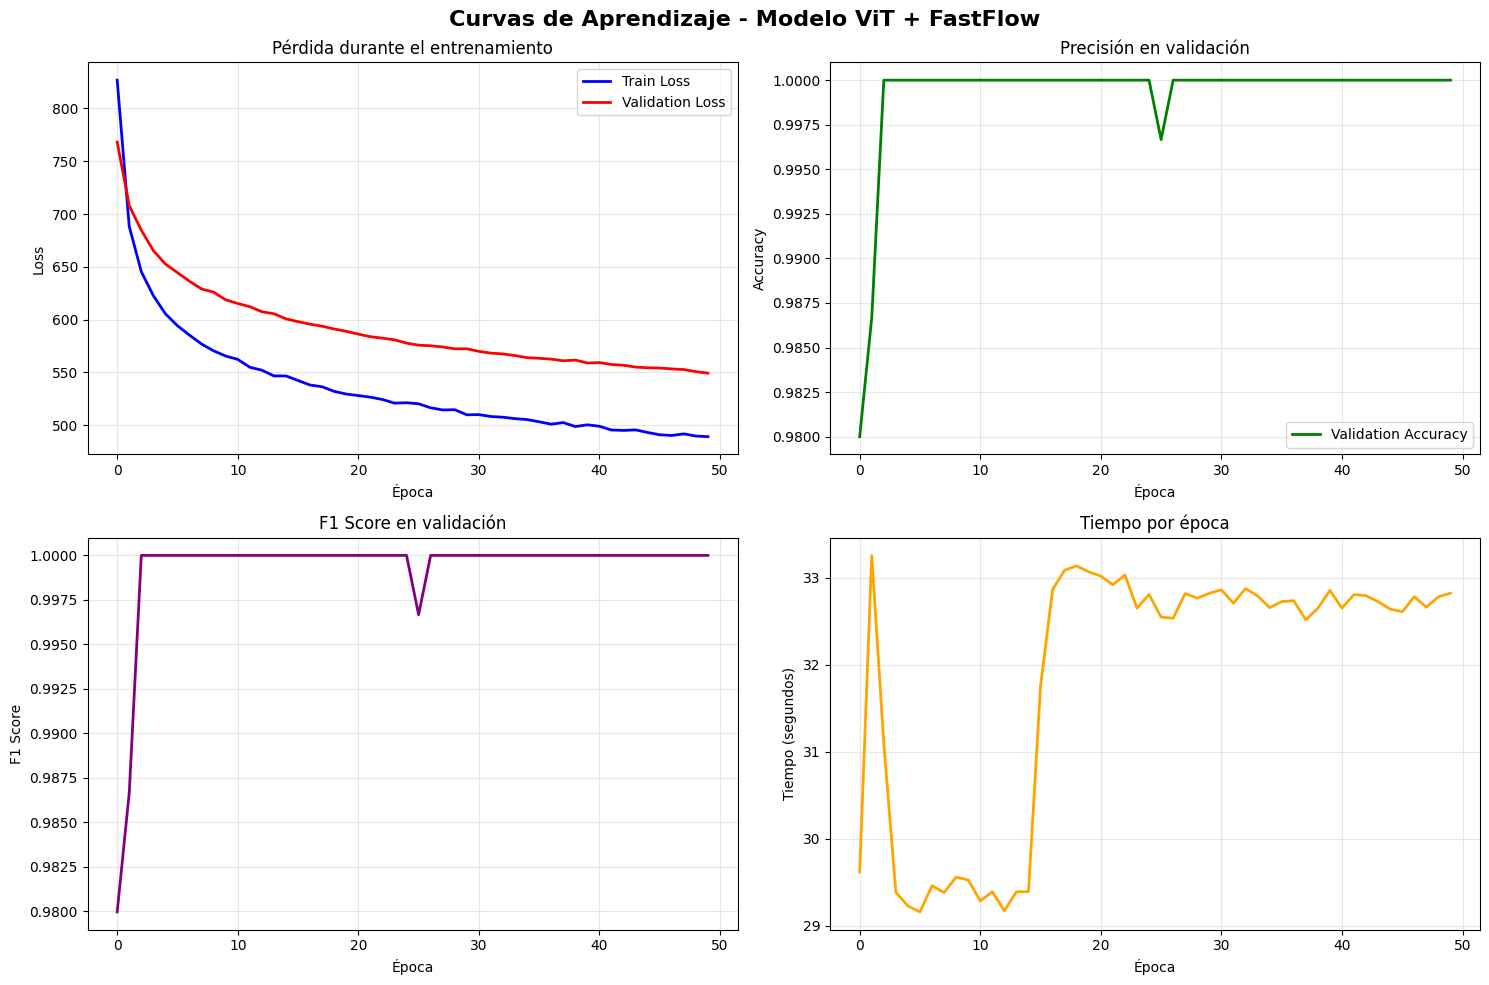

Gráficos guardados en training_plots.png
Modelo guardado en: best_model_vit_fastflow.pth


In [ ]:
# Inicializar modelo
if use_existing and existing_checkpoint:
    print("Cargando modelo ya entrenado...")
    model, _ = ViT_FastFlow_Complete.load_model(existing_model_path)
else:
    # Determinar número de clases del dataset
    if 'train' in datasets:
        num_classes = len(set(datasets['train'].classes))
    else:
        num_classes = 4 
    
    print(f"Creando nuevo modelo con {num_classes} clases...")
    model = ViT_FastFlow_Complete(num_classes=num_classes)
    
    # Entrenar solo si tenemos datos de entrenamiento
    if train_loader and val_loader:
        model, tracker = train_model(model, train_loader, val_loader)
    else:
        print("No se encontraron datos de entrenamiento/validación")

Evaluando en test: 100%|██████████| 19/19 [00:05<00:00,  3.65it/s]


\n==================================================
EVALUACIÓN EN TEST SET
\n=== Reporte de Clasificación (Clases) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        75
           1       1.00      1.00      1.00        75
           2       1.00      1.00      1.00        75
           3       1.00      1.00      1.00        75

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



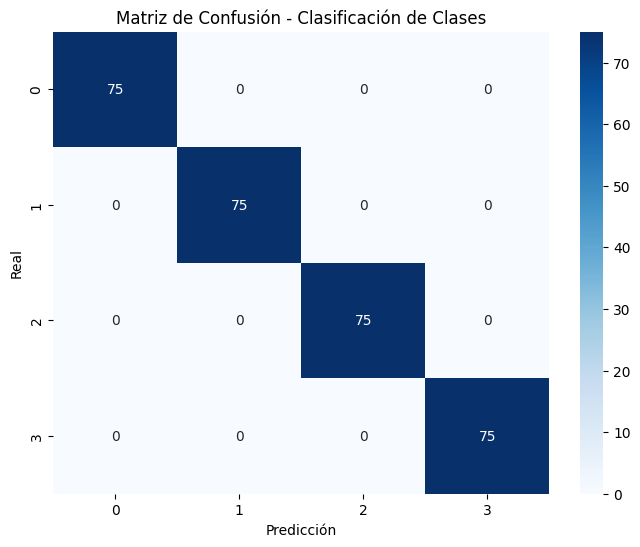

In [13]:
def evaluate_model(model, test_loader, device=None):
    """Evalúa el modelo en el conjunto de test"""
    if device is None:
        device = config.DEVICE
        
    model.eval()
    model = model.to(device)
    
    all_preds, all_labels, all_defects, all_scores = [], [], [], []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluando en test"):
            images = batch['image'].to(device)
            class_labels = batch['class'].to(device)
            defect_labels = batch['defect'].to(device)
            
            class_logits, anomaly_scores = model(images)
            preds = torch.argmax(class_logits, dim=1).cpu().numpy()
            
            all_preds.extend(preds)
            all_labels.extend(class_labels.cpu().numpy())
            all_defects.extend(defect_labels.cpu().numpy())
            all_scores.extend(anomaly_scores.cpu().numpy())
    
    # Métricas de clasificación
    print("\\n" + "="*50)
    print("EVALUACIÓN EN TEST SET")
    print("="*50)
    
    print("\\n=== Reporte de Clasificación (Clases) ===")
    print(classification_report(all_labels, all_preds))
    
    # Matriz de confusión para clasificación
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Matriz de Confusión - Clasificación de Clases")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()
    
    # Análisis de anomalías si hay defectos
    if any(all_defects):
        print("\\n=== Análisis de Detección de Anomalías ===")
        
        # Calcular threshold óptimo para anomalías
        from sklearn.metrics import roc_curve, auc
        fpr, tpr, thresholds = roc_curve(all_defects, all_scores)
        roc_auc = auc(fpr, tpr)
        
        # Encontrar threshold óptimo (Youden's J statistic)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        
        print(f"AUC-ROC para detección de anomalías: {roc_auc:.4f}")
        print(f"Threshold óptimo: {optimal_threshold:.4f}")
        
        # Predicciones binarias de anomalía
        anomaly_preds = (np.array(all_scores) > optimal_threshold).astype(int)
        
        print("\\nReporte de detección de anomalías:")
        print(classification_report(all_defects, anomaly_preds, 
                                  target_names=['Normal', 'Defectuoso']))
        
        # Gráfico ROC
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Curva ROC - Detección de Anomalías')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.show()
    
    return all_preds, all_labels, all_defects, all_scores

# Ejecutar evaluación si hay datos de test
if test_loader:
    preds, labels, defects, scores = evaluate_model(model, test_loader)
else:
    print("No se encontraron datos de test para evaluar")


In [19]:
def generate_heatmap(model, image_path, device=None, show_scores=True):
    """Genera heatmap de anomalías para una imagen específica"""
    if device is None:
        device = config.DEVICE
    
    if not os.path.exists(image_path):
        print(f"Error: No se encontró la imagen en {image_path}")
        return
    
    # Definir filename para usar dentro
    filename = os.path.basename(image_path)
    
    # Cargar y preprocesar imagen
    transform = val_transforms
    original_image = Image.open(image_path).convert("RGB")
    input_tensor = transform(original_image).unsqueeze(0).to(device)
    
    # Extraer features y hacer predicción
    model.eval()
    model = model.to(device)
    
    with torch.no_grad():
        class_logits, anomaly_score, features = model(input_tensor, return_features=True)
        
        # Predicción de clase
        predicted_class = torch.argmax(class_logits, dim=1).item()
        class_confidence = torch.softmax(class_logits, dim=1).max().item()
        
        # Score de anomalía
        anomaly_score = anomaly_score.item()
    
    # Generar mapa de activación
    activation_map = features.mean(dim=-1).squeeze().cpu().numpy()
    patch_features = activation_map[1:]
    grid_size = int(np.sqrt(len(patch_features)))
    
    if grid_size * grid_size == len(patch_features):
        activation_map = patch_features.reshape(grid_size, grid_size)
    else:
        activation_map = patch_features[:grid_size*grid_size].reshape(grid_size, grid_size)
    
    activation_map = cv2.resize(activation_map, (config.IMAGE_SIZE, config.IMAGE_SIZE))
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min() + 1e-8)
    
    heatmap = cv2.applyColorMap(np.uint8(255 * activation_map), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    original_resized = np.array(original_image.resize((config.IMAGE_SIZE, config.IMAGE_SIZE)))
    overlay = cv2.addWeighted(original_resized, 0.6, heatmap, 0.4, 0)
    
    # Visualización
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(original_image); axes[0].set_title("Imagen Original"); axes[0].axis('off')
    axes[1].imshow(activation_map, cmap='jet'); axes[1].set_title("Mapa de Activación"); axes[1].axis('off')
    axes[2].imshow(overlay); axes[2].set_title("Heatmap Superpuesto"); axes[2].axis('off')
    
    if show_scores:
        fig.suptitle(f"Análisis: {filename}\n"
                    f"Clase Predicha: {predicted_class} (Confianza: {class_confidence:.3f})\n"
                    f"Score de Anomalía: {anomaly_score:.4f}", 
                    fontsize=12, y=1.02)
    
    plt.tight_layout()
    plt.show()
    
    # Interpretación
    print(f"\n=== ANÁLISIS DE LA IMAGEN ===")
    print(f"Archivo: {filename}")
    print(f"Clase predicha: {predicted_class}")
    print(f"Confianza en clasificación: {class_confidence:.3f}")
    print(f"Score de anomalía: {anomaly_score:.4f}")
    
    threshold = 50.0  # ajustable según dataset
    is_defective = anomaly_score > threshold
    print(f"¿Es defectuosa? {'SÍ' if is_defective else 'NO'} (threshold: {threshold})")
    
    return {
        'predicted_class': predicted_class,
        'class_confidence': class_confidence,
        'anomaly_score': anomaly_score,
        'is_defective': is_defective
    }

## Sección de Inferencia - Análisis de Imagen Específica

En esta sección puedes analizar una imagen específica para:
1. **Clasificar el tipo de tablero** (clase 0, 1, 2, 3)
2. **Detectar si tiene defectos** usando el score de anomalía
3. **Visualizar un heatmap** que muestra las regiones más relevantes


Analizando imagen: ./defecto/20241014_200129_A.jpg


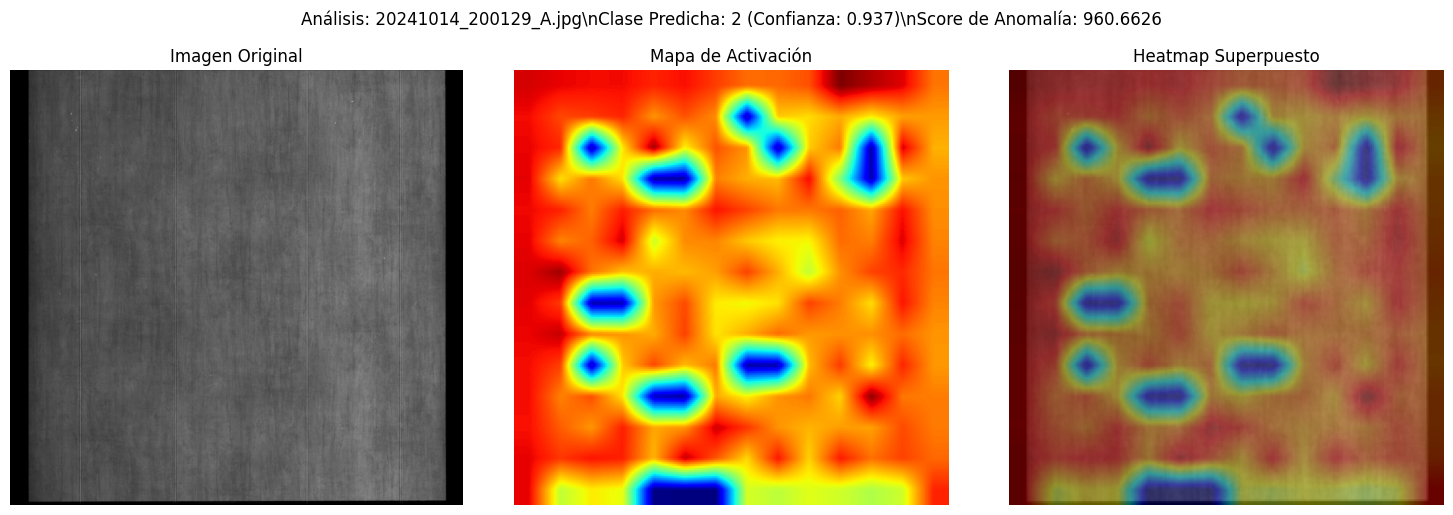

\n=== ANÁLISIS DE LA IMAGEN ===
Archivo: 20241014_200129_A.jpg
Clase predicha: 2
Confianza en clasificación: 0.937
Score de anomalía: 960.6626
¿Es defectuosa? SÍ (threshold: 50.0)
\n==================================================
RESULTADO DEL ANÁLISIS
Tipo de placa: Clase 2
Confianza: 93.7%
Score anomalía: 960.66
Estado: DEFECTUOSA


In [15]:
# ===== SECCIÓN DE INFERENCIA =====
# Modifica esta ruta con la imagen que quieres analizar
image_path = "./defecto/20241014_200129_A.jpg"  # CAMBIAR ESTA RUTA

# Verificar si la imagen existe
if os.path.exists(image_path):
    print(f"Analizando imagen: {image_path}")
    result = generate_heatmap(model, image_path, show_scores=True)
    
    # Mostrar resultado estructurado
    print("\\n" + "="*50)
    print("RESULTADO DEL ANÁLISIS")
    print("="*50)
    print(f"Tipo de placa: Clase {result['predicted_class']}")
    print(f"Confianza: {result['class_confidence']:.1%}")
    print(f"Score anomalía: {result['anomaly_score']:.2f}")
    print(f"Estado: {'DEFECTUOSA' if result['is_defective'] else 'NORMAL'}")
    
else:
    print(f"No se encontró la imagen en: {image_path}")
    
    # Mostrar algunas imágenes disponibles como ejemplo
    for split in ['train', 'val', 'test']:
        data_dir = os.path.join(config.DATASET_PATH, split)
        if os.path.exists(data_dir):
            files = [f for f in os.listdir(data_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            if files:
                print(f"  - {os.path.join(data_dir, files[0])}")
                if len(files) > 1:
                    print(f"  - {os.path.join(data_dir, files[1])}")

In [16]:
# Celda 18: Análisis batch de imágenes
def analyze_batch_images(model, image_dir, max_images=5):
    """Analiza múltiples imágenes de un directorio"""
    
    if not os.path.exists(image_dir):
        print(f"Directorio no encontrado: {image_dir}")
        return
    
    # Obtener lista de imágenes
    valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')
    image_files = [f for f in os.listdir(image_dir) 
                   if f.lower().endswith(valid_extensions)]
    
    if not image_files:
        print(f"No se encontraron imágenes en {image_dir}")
        return
    
    # Limitar número de imágenes
    image_files = image_files[:max_images]
    
    print(f"Analizando {len(image_files)} imágenes de {image_dir}...")
    print("="*60)
    
    results = []
    
    for i, filename in enumerate(image_files):
        image_path = os.path.join(image_dir, filename)
        print(f"\n[{i+1}/{len(image_files)}] {filename}")
        result = generate_heatmap(model, image_path, show_scores=False)
        results.append((filename, result))
    
    print("\n=== Resumen Batch ===")
    for filename, result in results:
        print(f"{filename}: clase={result['predicted_class']}, "
              f"defectuosa={'SÍ' if result['is_defective'] else 'NO'}, "
              f"score={result['anomaly_score']:.2f}")
    
    return results

Analizando 5 imágenes de ./test_defecto...

[1/5] 20241013_000046_A.jpg


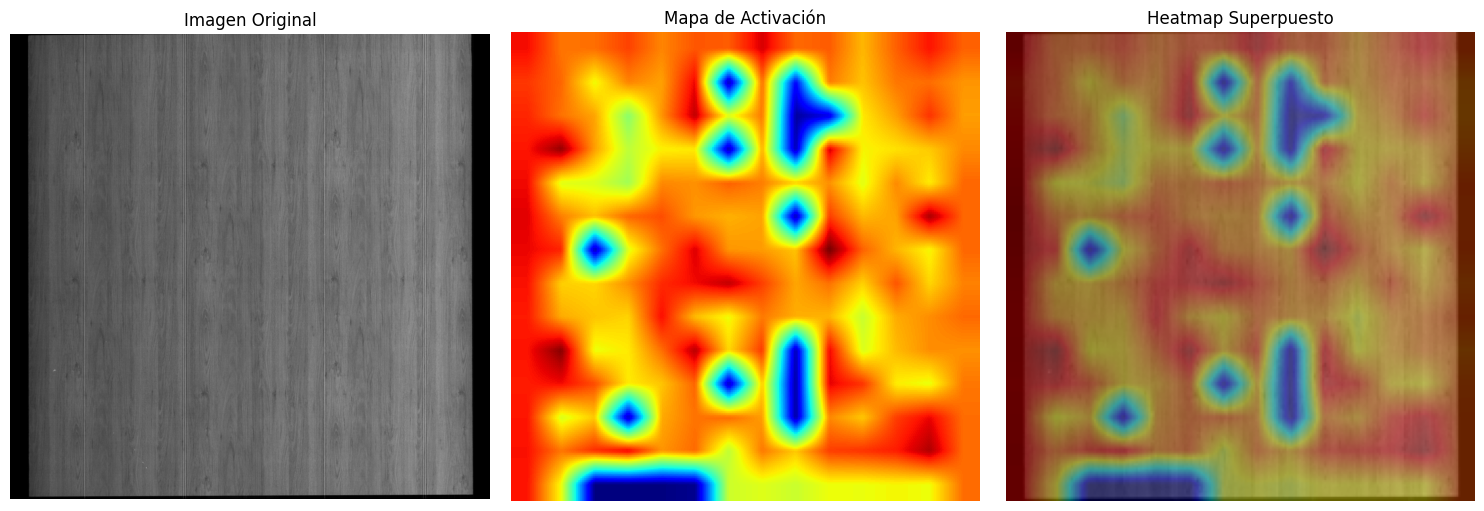


=== ANÁLISIS DE LA IMAGEN ===
Archivo: 20241013_000046_A.jpg
Clase predicha: 2
Confianza en clasificación: 0.970
Score de anomalía: 1046.2029
¿Es defectuosa? SÍ (threshold: 50.0)

[2/5] 20241013_000208_A.jpg


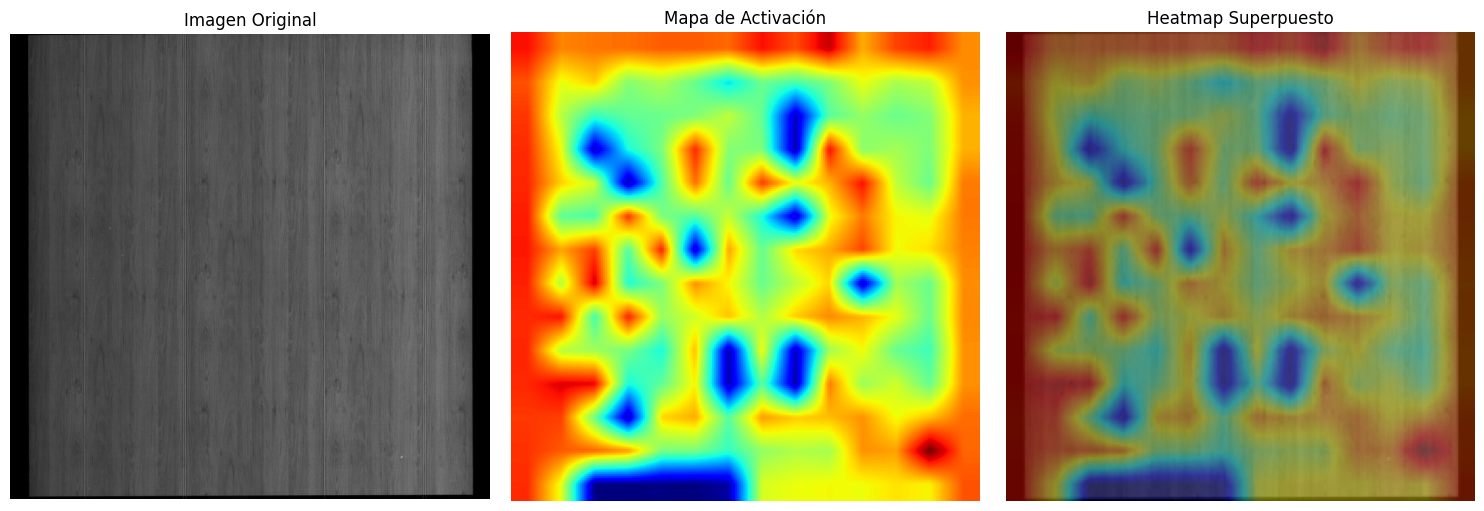


=== ANÁLISIS DE LA IMAGEN ===
Archivo: 20241013_000208_A.jpg
Clase predicha: 2
Confianza en clasificación: 0.944
Score de anomalía: 1049.7220
¿Es defectuosa? SÍ (threshold: 50.0)

[3/5] 20241014_200051_A.jpg


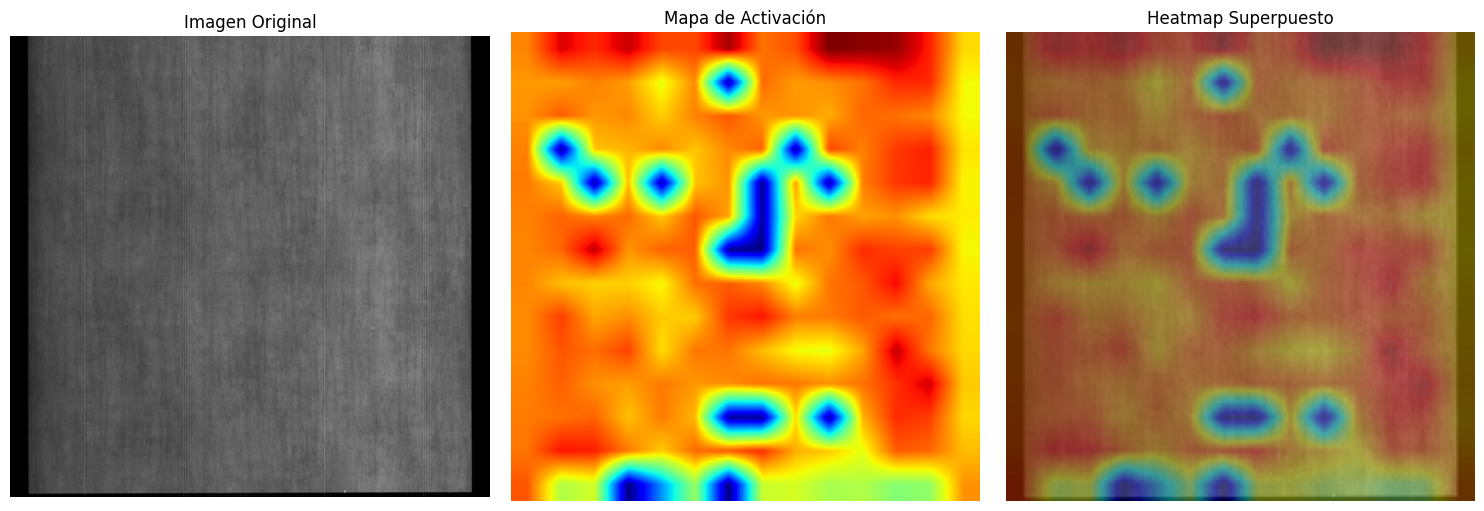


=== ANÁLISIS DE LA IMAGEN ===
Archivo: 20241014_200051_A.jpg
Clase predicha: 2
Confianza en clasificación: 0.841
Score de anomalía: 951.7458
¿Es defectuosa? SÍ (threshold: 50.0)

[4/5] 20241014_200208_A.jpg


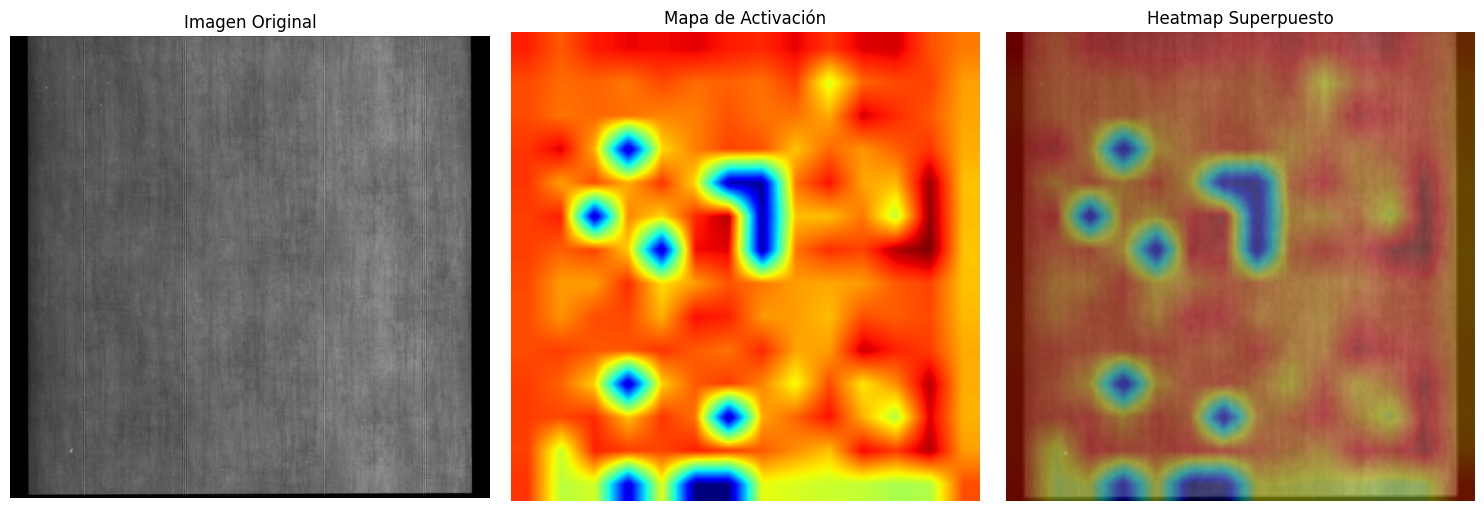


=== ANÁLISIS DE LA IMAGEN ===
Archivo: 20241014_200208_A.jpg
Clase predicha: 2
Confianza en clasificación: 0.895
Score de anomalía: 959.6453
¿Es defectuosa? SÍ (threshold: 50.0)

[5/5] 20241017_214516_A.jpg


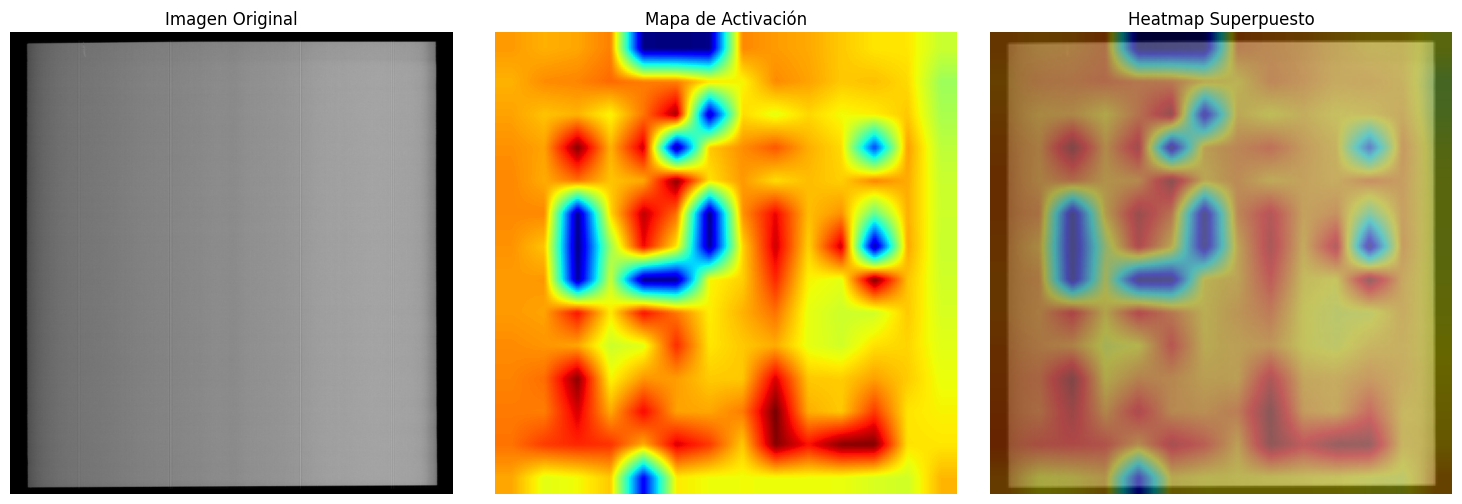


=== ANÁLISIS DE LA IMAGEN ===
Archivo: 20241017_214516_A.jpg
Clase predicha: 3
Confianza en clasificación: 0.700
Score de anomalía: 840.4372
¿Es defectuosa? SÍ (threshold: 50.0)

=== Resumen Batch ===
20241013_000046_A.jpg: clase=2, defectuosa=SÍ, score=1046.20
20241013_000208_A.jpg: clase=2, defectuosa=SÍ, score=1049.72
20241014_200051_A.jpg: clase=2, defectuosa=SÍ, score=951.75
20241014_200208_A.jpg: clase=2, defectuosa=SÍ, score=959.65
20241017_214516_A.jpg: clase=3, defectuosa=SÍ, score=840.44


In [ ]:
test_images_dir = "./test_defecto"

if os.path.exists(test_images_dir):
    batch_results = analyze_batch_images(model, test_images_dir, max_images=5)
else:
    print("Directorio test no encontrado para análisis batch.")